In [1]:
!pip install transformers

In [2]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import json
from subprocess import check_output
from transformers.data.processors.squad import SquadV2Processor
import seaborn as sns

/opt/conda/lib/python3.10/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.23.5
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


In [3]:
def json_to_dataframe():
  processor = SquadV2Processor()
  examples = processor.get_train_examples('/kaggle/input/squad-2/')
  qas_id = [example.qas_id for example in examples]
  question_text = [example.question_text for example in examples]
  context_text = [example.context_text for example in examples]
  answer_text = [example.answer_text for example in examples]
  start_position = [example.start_position for example in examples]
  end_position = [example.end_position for example in examples]
  is_impossible = [example.is_impossible for example in examples]

  # create the DataFrame
  df = pd.DataFrame({
      'qas_id': qas_id,
      'question_text': question_text,
      'context_text': context_text,
      'answer_text': answer_text,
      'start_position': start_position,
      'end_position': end_position,
      'is_impossible': is_impossible,
  })
  return df

In [4]:
sns.set_palette("viridis")

In [5]:
df = json_to_dataframe()

100%|██████████| 442/442 [00:50<00:00,  8.72it/s]


# Plots

**Distribution of question and answer lengths**

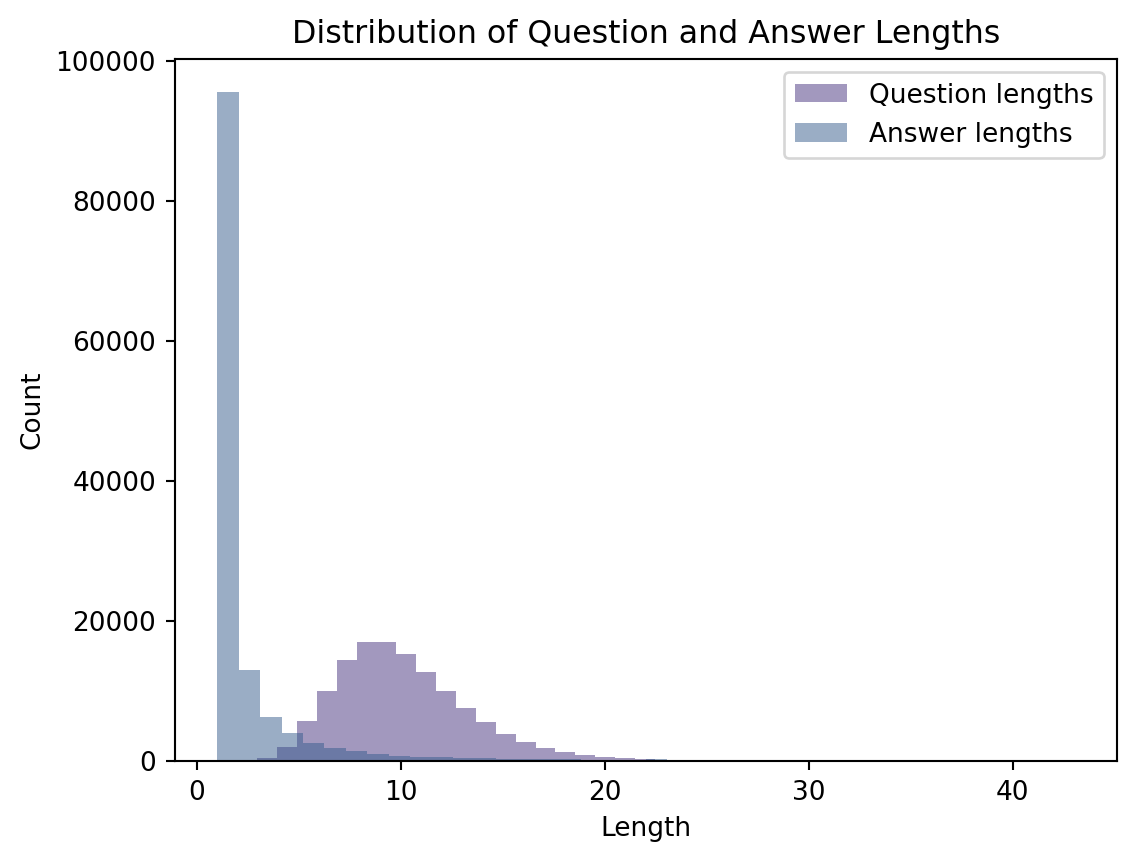

In [6]:
# Point 1: Distribution of question and answer lengths
question_lengths = df['question_text'].astype(str).apply(lambda x: len(x.split()))
answer_lengths = df['answer_text'].astype(str).apply(lambda x: len(x.split()))
plt.figure(dpi=190)
plt.hist(question_lengths, bins=40, alpha=0.5, label='Question lengths')
plt.hist(answer_lengths, bins=40, alpha=0.5, label='Answer lengths')
plt.title('Distribution of Question and Answer Lengths')
plt.xlabel('Length')
plt.ylabel('Count')
plt.legend()
plt.show()

**Distribution of answer types**

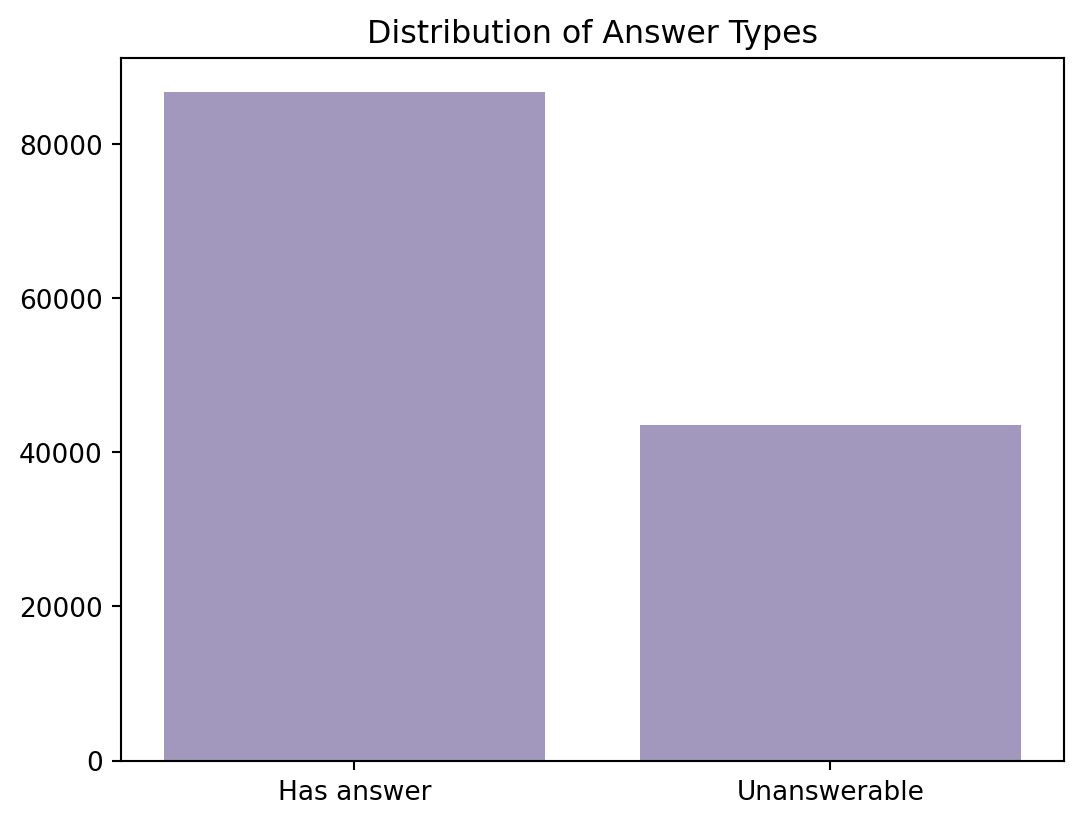

In [7]:
# Point 2: Distribution of answer types
answer_types = df['is_impossible'].value_counts()
plt.figure(dpi=190)
plt.bar(['Has answer', 'Unanswerable'], answer_types, alpha=0.5)
plt.title('Distribution of Answer Types')
plt.show()

**Count the frequency of different answer types**

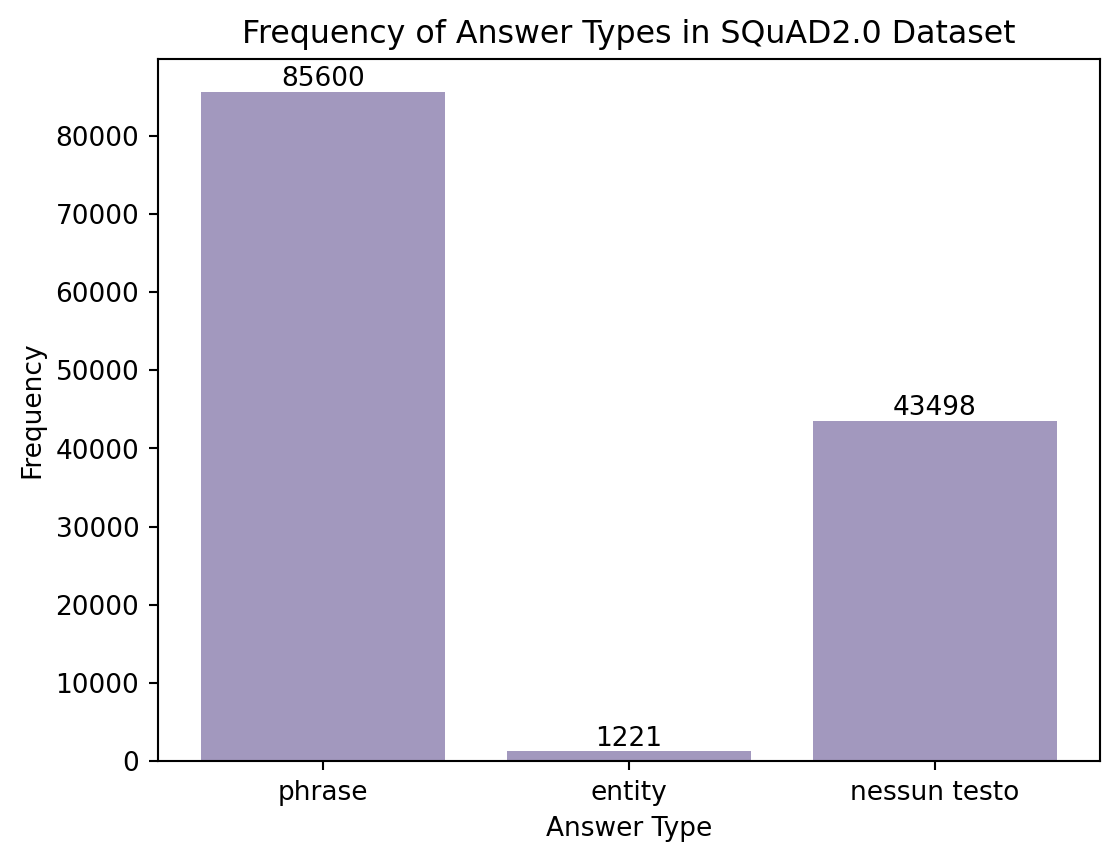

In [8]:
answer_types = {}
for i in range(len(df)):
    answer_text = df.loc[i, 'answer_text']
    if answer_text is None:
        answer_type = 'nessun testo'
    elif isinstance(answer_text, int):
        answer_type = 'number'
    elif answer_text.isupper():
        answer_type = 'entity'
    else:
        answer_type = 'phrase'
    answer_types[answer_type] = answer_types.get(answer_type, 0) + 1

# Create a bar chart showing the frequency of different answer types
labels = list(answer_types.keys())
values = list(answer_types.values())
plt.figure(dpi = 190)
plt.bar(labels, values, alpha = 0.5)
for i, v in enumerate(values):
    plt.text(i, v, str(v), ha='center', va='bottom')
plt.title('Frequency of Answer Types in SQuAD2.0 Dataset')
plt.xlabel('Answer Type')
plt.ylabel('Frequency')
plt.show()


**Cluster visualization**

In [9]:
from sklearn.manifold import TSNE
from sklearn.neighbors import NearestNeighbors, KNeighborsClassifier
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
from matplotlib.lines import Line2D
from sklearn.feature_extraction.text import TfidfVectorizer

In [10]:
def tsne_clusters(df):
    vectorizer = TfidfVectorizer(stop_words='english')
    X = vectorizer.fit_transform(df)
    # Fit a nearest neighbor model to the data
    nn_model = NearestNeighbors(n_neighbors=3, metric = 'cosine')
    nn_model.fit(X)
    
    # Get the nearest neighbors graph
    knn_graph = nn_model.kneighbors_graph(X).toarray()
    
    # Get the t-SNE embedded coordinates
    tsne_embedded = TSNE(n_components=2, perplexity=50, random_state=42, init = 'random', n_jobs = -1).fit_transform(X)
    
    # Get the cluster labels
    labels = np.argmax(knn_graph, axis=1)
    print(labels)
    
    # Set the colormap
    cmap = plt.get_cmap('rainbow')
    
    # Create a scatter plot of the t-SNE embedded coordinates, colored by cluster
    plt.figure(figsize=(8, 8))
    plt.scatter(tsne_embedded[:, 0], tsne_embedded[:, 1], c=labels, cmap=cmap)
    plt.title('t-SNE Clusters')
    plt.xlabel('t-SNE Dimension 1')
    plt.ylabel('t-SNE Dimension 2')
    
    # Add a legend to the scatter plot
    legend_elements = [Line2D([0], [0], marker='o', color='w', label='Cluster {}'.format(i), markerfacecolor=cmap(i)) for i in range(len(np.unique(labels)))]
    plt.legend(handles=legend_elements, loc='best')
    
    
    plt.show()

In [11]:
def cluster_plot(df):
    vectorizer = TfidfVectorizer()
    X = vectorizer.fit_transform(df['context_text'])
    # Perform KNN for clustering
    k = 5  # Choose the number of clusters
    knn = KNeighborsClassifier(n_neighbors=k, n_jobs = -1)
    knn.fit(X, [i // (len(df) // k) for i in range(len(df))])  # Assign labels based on indices

    # Perform t-SNE for visualization
    tsne = TSNE(n_components=2, perplexity=30, random_state=42, init = 'random', n_jobs = -1)
    X_tsne = tsne.fit_transform(X.toarray())

    # Plot the clusters
    plt.scatter(X_tsne[:, 0], X_tsne[:, 1], c=knn.predict(X), cmap='rainbow')
    plt.legend()
    plt.show()

In [12]:
# Get a sample of 500 context texts
sample_size = 1000
df_sample = df.sample(sample_size, random_state=42)

In [13]:
len(df_sample['context_text'])

1000

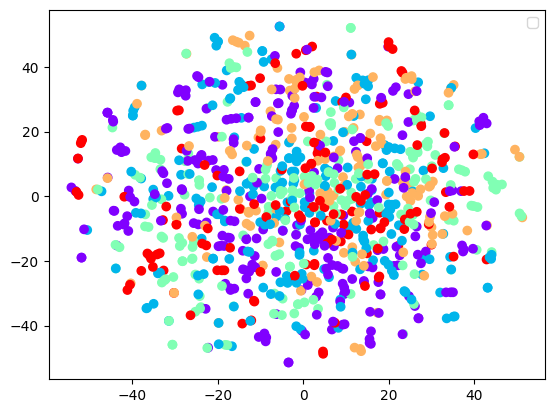

In [14]:
cluster_plot(df_sample)